# PyTorch Metric Learning
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install the packages

In [88]:
!pip install pytorch-metric-learning
!git clone https://github.com/akamaster/pytorch_resnet_cifar10

fatal: destination path 'pytorch_resnet_cifar10' already exists and is not an empty directory.


## Import the packages

In [0]:
%matplotlib inline
from pytorch_resnet_cifar10 import resnet # pretrained models from https://github.com/akamaster/pytorch_resnet_cifar10
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
from pytorch_metric_learning.utils import common_functions as c_f
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np

## Create helper functions

In [0]:
def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Create the dataset and load the trained model

In [91]:
transform = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize(mean=mean, std=std)])

dataset = datasets.CIFAR10(root="CIFAR10_Dataset", train=False, transform=transform, download=True)
labels_to_indices = c_f.get_labels_to_indices(dataset.targets)
model = torch.nn.DataParallel(resnet.resnet20())
checkpoint = torch.load("pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th")
model.load_state_dict(checkpoint['state_dict'])
model.linear = c_f.Identity() 
model.to(torch.device("cuda"))
print("done model loading")

Files already downloaded and verified
done model loading


## Create the InferenceModel wrapper

In [0]:
match_finder = MatchFinder(mode="sim", threshold=0.7)
inference_model = InferenceModel(model, match_finder=match_finder)

# cars and frogs
classA, classB = labels_to_indices[1], labels_to_indices[6]

## Compare two images of the same class

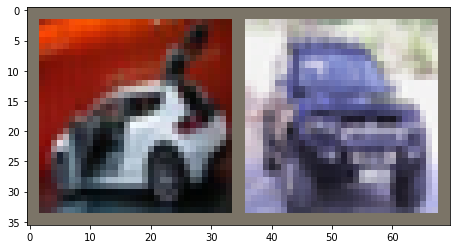

Same class


In [93]:
# compare two images of the same class
(x, _), (y, _) = dataset[classA[0]], dataset[classA[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare two images of different classes

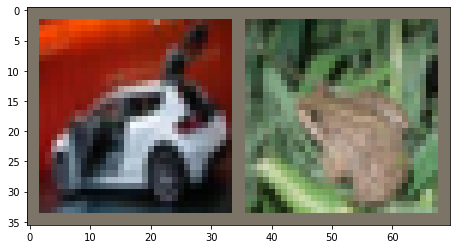

Different class


In [94]:
# compare two images of a different class
(x, _), (y, _) = dataset[classA[0]], dataset[classB[0]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare multiple pairs of images

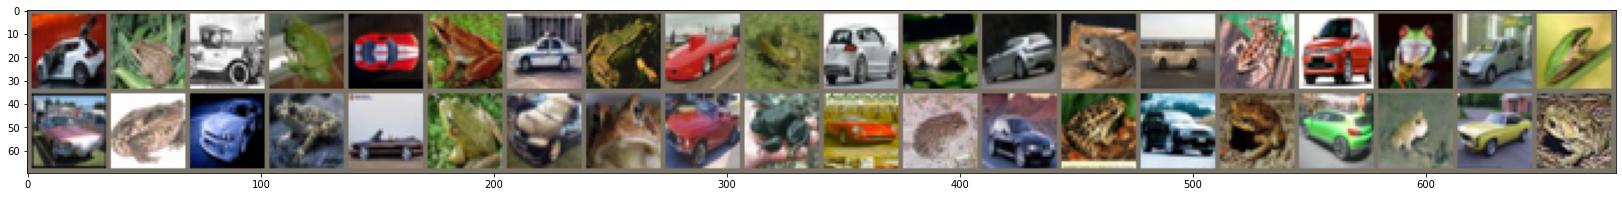

Same class
Same class
Same class
Same class
Same class
Same class
Same class
Different class
Same class
Different class
Same class
Different class
Same class
Same class
Different class
Different class
Same class
Same class
Same class
Different class
accuracy = 0.7


In [95]:
# compare multiple pairs of images
x = torch.zeros(20, 3, 32, 32)
y = torch.zeros(20, 3, 32, 32)
for i in range(0, 20, 2):
    x[i] = dataset[classA[i]][0]
    x[i+1] = dataset[classB[i]][0]
    y[i] = dataset[classA[i+20]][0]
    y[i+1] = dataset[classB[i+20]][0]
imshow(torchvision.utils.make_grid(torch.cat((x,y), dim=0), nrow=20), figsize=(30, 3))
decision = inference_model.is_match(x, y)
for d in decision:
    print_decision(d)
print("accuracy = {}".format(np.sum(decision)/len(x)))

## Compare all pairs within a batch

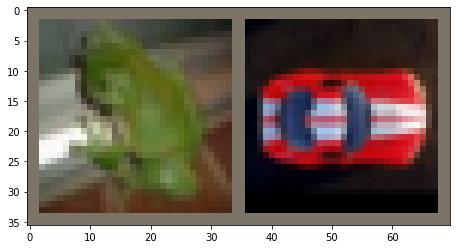

Different class


In [96]:
# compare all pairs within a batch
match_matrix = inference_model.get_matches(x)
assert match_matrix[0,0] # the 0th image should match with itself
imshow(torchvision.utils.make_grid(torch.stack((x[3],x[4]), dim=0)))
print_decision(match_matrix[3,4]) # does the 3rd image match the 4th image?

## Compare all pairs between queries and references

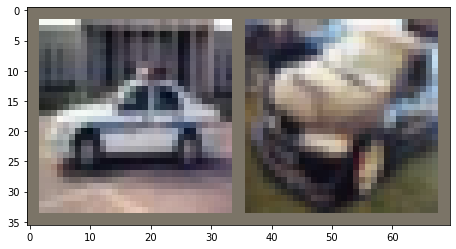

Same class


In [97]:
# compare all pairs between queries and references
match_matrix = inference_model.get_matches(x, y)
imshow(torchvision.utils.make_grid(torch.stack((x[6],y[6]), dim=0)))
print_decision(match_matrix[6, 6]) # does the 6th query match the 6th reference?

# Get results in tuple form

MATCHING IMAGE PAIRS
3 5


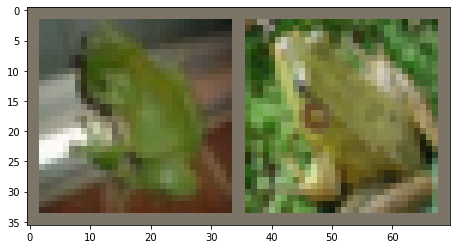

6 14


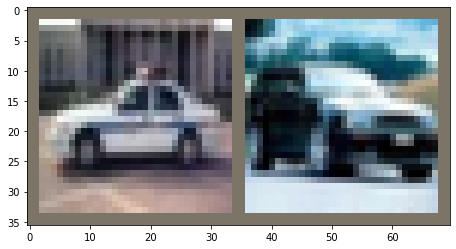

7 3


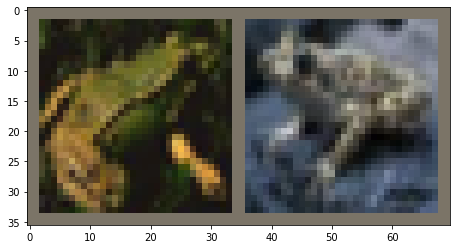

7 13


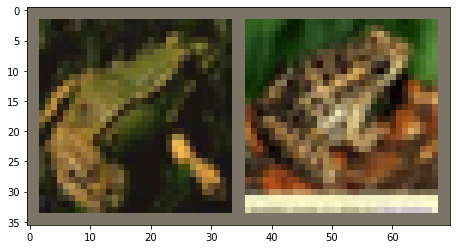

10 12


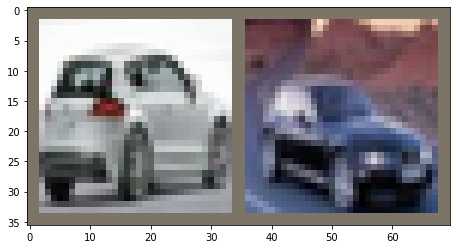

12 14


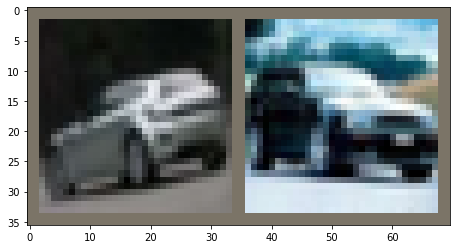

13 3


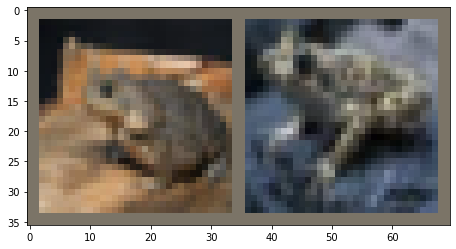

16 0


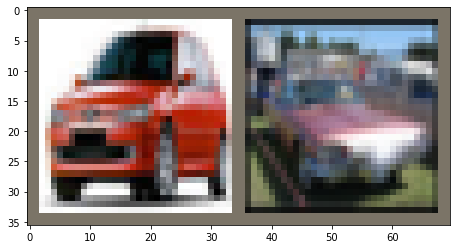

16 18


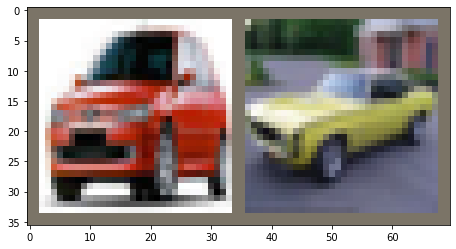

17 5


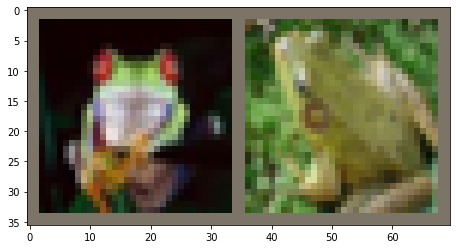

17 13


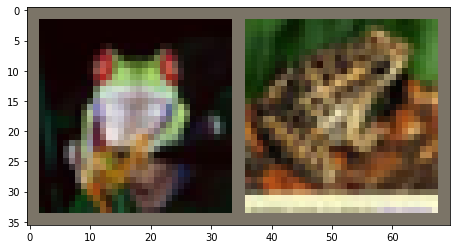

18 10


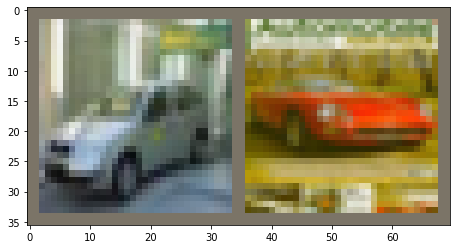

In [98]:
# make a new model with high threshold
match_finder = MatchFinder(mode="sim", threshold=0.95)
inference_model = InferenceModel(model, match_finder=match_finder)

# get all matches in tuple form
match_tuples = inference_model.get_matches(x, y, return_tuples=True)
print("MATCHING IMAGE PAIRS")
for i,j in match_tuples:
    print(i,j)
    imshow(torchvision.utils.make_grid(torch.stack((x[i],y[j]), dim=0)))